In [68]:
# Import modules & tools

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [69]:
# Import datasets

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [70]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [71]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [72]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [73]:
# Remove unnecessary columns (not relevant to training result, many missing fields)

train_df = train_df.drop(columns=['keyword', 'location'])
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
test_df = test_df.drop(columns=['keyword', 'location'])
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [75]:
train_df.shape, test_df.shape

((7613, 3), (3263, 2))

In [77]:
# Install kgptalkie

#!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

In [78]:
import preprocess_kgptalkie as ps

In [79]:
# Clean data

train_df['text'] = train_df['text'].apply(lambda x: ps.cont_exp(x))
train_df['text'] = train_df['text'].apply(lambda x: ps.remove_accented_chars(x))
train_df['text'] = train_df['text'].apply(lambda x: ps.remove_emails(x))
train_df['text'] = train_df['text'].apply(lambda x: ps.remove_urls(x))
train_df['text'] = train_df['text'].apply(lambda x: ps.make_base(x))
train_df['text'] = train_df['text'].apply(lambda x: str(x).lower())
train_df['text'] = train_df['text'].apply(lambda x: ps.remove_special_chars(x))

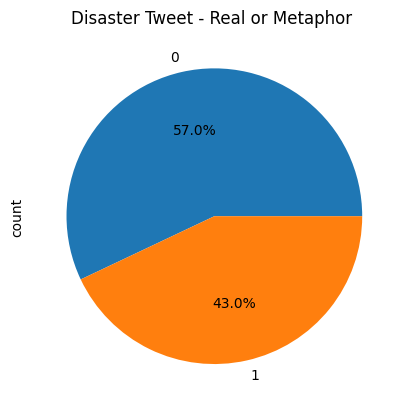

In [80]:
# Review real (1) vs metaphorical (0) disaster distribution

train_df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Disaster Tweet - Real or Metaphor ')
plt.show()

In [81]:
# Check basic features of training dataframe

features = ps.get_basic_features(train_df)
features.head()

,id,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,our deed are the reason of this earthquake may...,1,55,13,4.230769,8,0,0,0,0
1,4,forest fire near la ronge sask canada,1,31,7,4.428571,0,0,0,0,0
2,5,all resident ask to shelter in place are being...,1,100,22,4.545455,11,0,0,0,0
3,6,13000 people receive wildfire evacuation order...,1,53,8,6.625000,1,0,0,1,0
4,7,just get send this photo from ruby alaska as s...,1,68,16,4.250000,8,0,0,0,0


In [55]:
# Explore best model

# Import classification models

from sklearn.tree import DecisionTreeClassifier     # Decision Tree Classification
from sklearn.ensemble import RandomForestClassifier # Random Forest Classification
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors
from sklearn.svm import SVC                         # Support Vector Machine

In [56]:
# Create arrays

X = train_df['text']
y = train_df['target']

In [57]:
# Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(X)

In [58]:
# Splitting data.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [60]:
# Models parameters

models = {
    'Logistic Regression':LogisticRegression(random_state=0),
    'K-Nearest Neighbors':KNeighborsClassifier(metric='minkowski', n_neighbors=5, p=2),
    'Support Vector Machine':SVC(kernel='linear', random_state=0),
    'Kernel Support Vector Machine':SVC(kernel='rbf', random_state=0),
    'Decision Tree Classification':DecisionTreeClassifier(criterion='entropy', random_state=0),
    'Random Forest Classification':RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0),
}

In [61]:
# Model evaluation.
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print(f'Model: {name}')
  print(confusion_matrix(y_test, y_pred))
  print("Accuracy (single): {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
  accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
  print("Accuracy (k-fold): {:.2f}%".format(accuracies.mean()*100))
  print("Standard Deviation: {:.2f}%".format(accuracies.std()*100))
  print('------------------------------------------------')

Model: Logistic Regression
[[799  70]
 [204 450]]
Accuracy (single): 82.01%
Accuracy (k-fold): 80.21%
Standard Deviation: 1.03%
------------------------------------------------
Model: K-Nearest Neighbors
[[859  10]
 [514 140]]
Accuracy (single): 65.59%
Accuracy (k-fold): 64.99%
Standard Deviation: 0.62%
------------------------------------------------
Model: Support Vector Machine
[[787  82]
 [195 459]]
Accuracy (single): 81.81%
Accuracy (k-fold): 80.21%
Standard Deviation: 1.49%
------------------------------------------------
Model: Kernel Support Vector Machine
[[804  65]
 [223 431]]
Accuracy (single): 81.09%
Accuracy (k-fold): 80.34%
Standard Deviation: 1.35%
------------------------------------------------
Model: Decision Tree Classification
[[684 185]
 [224 430]]
Accuracy (single): 73.15%
Accuracy (k-fold): 71.58%
Standard Deviation: 1.49%
------------------------------------------------
Model: Random Forest Classification
[[799  70]
 [257 397]]
Accuracy (single): 78.53%
Accuracy

In [62]:
# Model accuracy, in order from best model to lesser model

# Logistic Regression - 82.01%
# SVM - 81.81%
# Kernel SVM - 81.09%
# Random Forest - 78.53%
# Decision Tree - 73.15%
# KNN - 65.59%

In [64]:
# Training with logistic regression

# Setting data arrays.
X_train = train_df['text']
y_train = train_df['target']

X_test = test_df['text']

# Applying TF-IDF vectorization to data.
tfidf = TfidfVectorizer(max_features=10000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Train the model.
model = LogisticRegression(C=1, penalty='l2', solver='lbfgs', random_state=0)
model.fit(X_train, y_train)

# Predict the data.
y_pred = model.predict(X_test)

In [66]:
# Export Results

results = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred
})

results.to_csv('results.csv', index=False)

In [67]:
results.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
